
## What is Sentiment Analysis?
Sentiment Analysis is the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

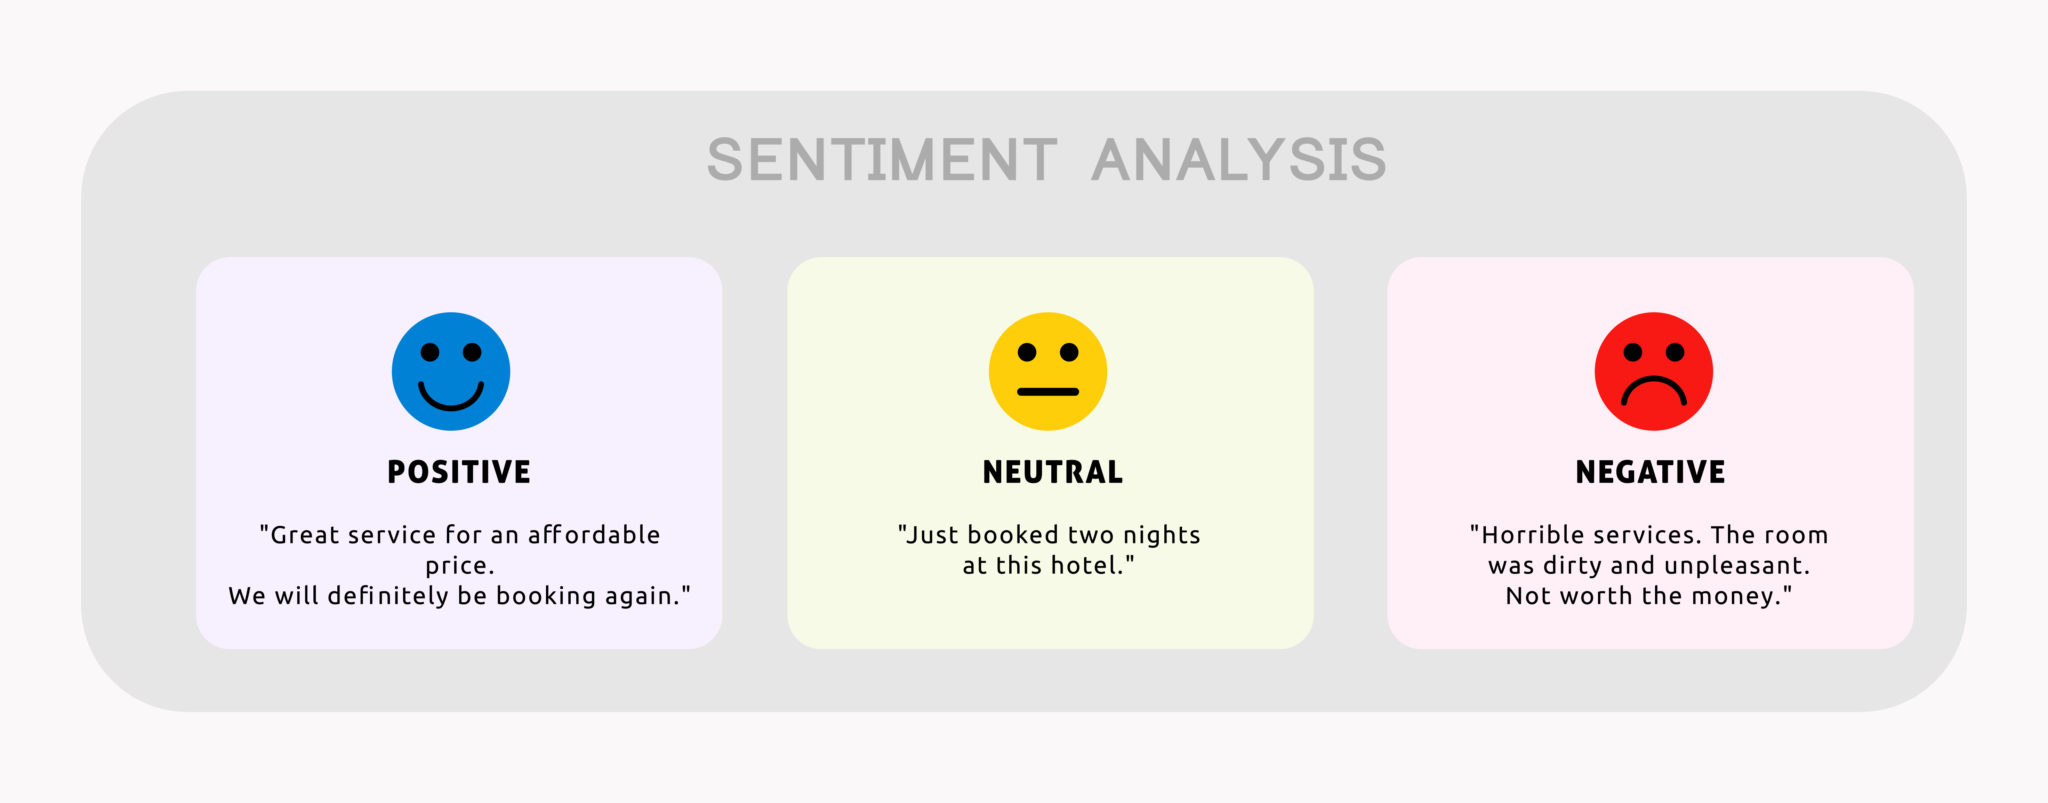

In [43]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
import string
import re

Explanation:

>Warnings Filter: Suppresses warnings for cleaner output.

>Pandas: Used for data manipulation and analysis.

>Matplotlib & Seaborn: Used for data visualization.

>WordCloud: For generating word cloud visualizations.

>SKLearn (scikit-learn): Provides tools for machine learning, including model selection, data splitting, feature extraction, model training, and evaluation.

>Pickle: Used for saving the trained model to disk.

In [26]:
import praw
from transformers import pipeline, BertTokenizer

# Initialize Reddit instance
reddit = praw.Reddit(
    client_id="Adgs1BqKFWPstMUG3G4MZA",        # client_id from the Reddit application
    client_secret="G5ekLZQxg43T87UTrmwxZcacCGkGeQ", # client_secret from the Reddit application
    user_agent="Reddit_Sentiment_Analysis",      # A string that describes the application's purpose
)

# Select Politics subreddit
subreddit = reddit.subreddit("politics")

comments_data = []

# Fetch top posts and their comments
for submission in subreddit.hot(limit=10):  # Adjust limit to fetch more data
    submission.comments.replace_more(limit=0)
    for comment in submission.comments.list():
        comments_data.append({
            'comment': comment.body,
            'score': comment.score,
            'created_utc': comment.created_utc
        })

# Convert to pandas DataFrame
comments_df = pd.DataFrame(comments_data)
print(comments_df.head())

# Use multi-class sentiment classification model
sentiment_analysis = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion")



                                             comment  score   created_utc
0  To sort this thread by 'best comments first', ...      1  1.723464e+09
1  [Bank of America CEO says research team ‘does ...      1  1.723478e+09
2  Truth Social made $837K in gross revenue in a ...     37  1.723466e+09
3  Gotta say, even after weeks of it, Beyoncé’s F...      1  1.723492e+09
4  >Harris is up 2 pts (within the MOE) over Trum...      1  1.723476e+09


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [27]:

from transformers import pipeline, BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to handle overly long texts
def analyze_sentiment(text):
    # Tokenize and forcefully truncate the text to a maximum of 512 tokens
    encoded_input = tokenizer(text, truncation=True, max_length=512, return_tensors='pt', padding='max_length')
    truncated_text = tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)
    return sentiment_analysis(truncated_text)[0]['label']

# Perform sentiment analysis on the fetched comments, ensuring that text length is strictly within 512 tokens
comments_df['sentiment'] = comments_df['comment'].apply(analyze_sentiment)

print(comments_df.head())

comments_df.to_csv('reddit_politics_sentiments.csv', index=False)


                                             comment  score   created_utc  \
0  To sort this thread by 'best comments first', ...      1  1.723464e+09   
1  [Bank of America CEO says research team ‘does ...      1  1.723478e+09   
2  Truth Social made $837K in gross revenue in a ...     37  1.723466e+09   
3  Gotta say, even after weeks of it, Beyoncé’s F...      1  1.723492e+09   
4  >Harris is up 2 pts (within the MOE) over Trum...      1  1.723476e+09   

  sentiment  
0       joy  
1   sadness  
2       joy  
3       joy  
4       joy  


In [54]:
df = pd.read_csv("./reddit_politics_sentiments.csv", encoding = "ISO-8859-1", engine="python")
df.head() # viewing top 5 rows of the dataframe

,comment,score,created_utc,sentiment
0,"To sort this thread by 'best comments first', ...",1,1.723464e+09,joy
1,[Bank of America CEO says research team âdoe...,1,1.723478e+09,sadness
2,Truth Social made $837K in gross revenue in a ...,37,1.723466e+09,joy
3,"Gotta say, even after weeks of it, BeyoncÃ©â...",1,1.723492e+09,joy
4,>Harris is up 2 pts (within the MOE) over Trum...,1,1.723476e+09,joy


In [55]:
df.shape # shape of the data
df.info() # data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   comment      4193 non-null   object 
 1   score        4193 non-null   int64  
 2   created_utc  4193 non-null   float64
 3   sentiment    4193 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 131.2+ KB


In [56]:
df.isna().sum()*100 # checking for null values

comment        0
score          0
created_utc    0
sentiment      0
dtype: int64

In [57]:
df=df[['comment','sentiment']] # Selecting the text and label coloumn
df.head()

,comment,sentiment
0,"To sort this thread by 'best comments first', ...",joy
1,[Bank of America CEO says research team âdoe...,sadness
2,Truth Social made $837K in gross revenue in a ...,joy
3,"Gotta say, even after weeks of it, BeyoncÃ©â...",joy
4,>Harris is up 2 pts (within the MOE) over Trum...,joy


In [58]:
df['comment']=df['comment'].str.lower() # Making statement text in lower case¶
df['comment'].head()

0    to sort this thread by 'best comments first', ...
1    [bank of america ceo says research team âdoe...
2    truth social made $837k in gross revenue in a ...
3    gotta say, even after weeks of it, beyoncã©â...
4    >harris is up 2 pts (within the moe) over trum...
Name: comment, dtype: object

In [59]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english') # Cleaning and removing Stop words of english
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

Cleaning and removing the above stop words list from the reddit text

In [60]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['comment'] = df['comment'].apply(lambda text: cleaning_stopwords(text))
df['comment'].head()

0    sort thread 'best comments first', [click tap ...
1    [bank america ceo says research team âdoes r...
2    truth social made $837k gross revenue quarter....
3    gotta say, even weeks it, beyoncã©âs freedom...
4    >harris 2 pts (within moe) trump great lake ba...
Name: comment, dtype: object

In [61]:
# Cleaning and removing punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['comment']= df['comment'].apply(lambda x: cleaning_punctuations(x))
df['comment'].head()

0    sort thread best comments first click tap here...
1    bank america ceo says research team âdoes re...
2    truth social made 837k gross revenue quarter q...
3    gotta say even weeks it beyoncã©âs freedom g...
4    harris 2 pts within moe trump great lake battl...
Name: comment, dtype: object

In [62]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text) # Cleaning and removing repeating characters
df['comment'] = df['comment'].apply(lambda x: cleaning_repeating_char(x))
df['comment'].head()

0    sort thread best coments first click tap hereh...
1    bank america ceo says research team âdoes re...
2    truth social made 837k gros revenue quarter qu...
3    gota say even weks it beyoncã©âs fredom gets...
4    haris 2 pts within moe trump great lake batleg...
Name: comment, dtype: object

In [63]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data) # Cleaning and removing email
df['comment']= df['comment'].apply(lambda x: cleaning_email(x))
df['comment'].head()

0    sort thread best coments first click tap hereh...
1    bank america ceo says research team âdoes re...
2    truth social made 837k gros revenue quarter qu...
3    gota say even weks it beyoncã©âs fredom gets...
4    haris 2 pts within moe trump great lake batleg...
Name: comment, dtype: object

In [64]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data) # Cleaning and removing URL's
df['comment'] = df['comment'].apply(lambda x: cleaning_URLs(x))
df['comment'].head()

0    sort thread best coments first click tap hereh...
1    bank america ceo says research team âdoes re...
2    truth social made 837k gros revenue quarter qu...
3    gota say even weks it beyoncã©âs fredom gets...
4    haris 2 pts within moe trump great lake batleg...
Name: comment, dtype: object

In [65]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data) # Cleaning and removing Numeric numbers
df['comment'] = df['comment'].apply(lambda x: cleaning_numbers(x))
df['comment'].head()

0    sort thread best coments first click tap hereh...
1    bank america ceo says research team âdoes re...
2    truth social made k gros revenue quarter quart...
3    gota say even weks it beyoncã©âs fredom gets...
4    haris  pts within moe trump great lake batlegr...
Name: comment, dtype: object

In [91]:
def cleaning_numbers(data):
    return re.sub(r'[^A-Za-z0-9\s]+', '', data) # Cleaning and removing Numeric numbers
df['comment'] = df['comment'].apply(lambda x: cleaning_numbers(x))
df['comment'].head()

0    sort thread best coments first click tap hereh...
1    bank america ceo says research team does reces...
2    truth social made k gros revenue quarter quart...
3    gota say even weks it beyoncs fredom gets pump...
4    haris  pts within moe trump great lake batlegr...
Name: comment, dtype: object

In [66]:
df.head()

,comment,sentiment
0,sort thread best coments first click tap hereh...,joy
1,bank america ceo says research team âdoes re...,sadness
2,truth social made k gros revenue quarter quart...,joy
3,gota say even weks it beyoncã©âs fredom gets...,joy
4,haris pts within moe trump great lake batlegr...,joy


In [68]:
# Data Information
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    4193 non-null   object
 1   sentiment  4193 non-null   object
dtypes: object(2)
memory usage: 65.6+ KB
None
comment      0
sentiment    0
dtype: int64


In [69]:
# Display the distribution of sentiments
print(df['sentiment'].value_counts())

sentiment
joy         1844
anger       1540
sadness      461
fear         193
surprise      99
love          56
Name: count, dtype: int64


In [71]:
# Ensure the 'comment' column is string type and handle NaN values
df['comment'] = df['comment'].astype(str)

# Feature extraction functions
def char_counts(text):
    return len(text) if text else 0

def word_counts(text):
    return len(text.split()) if text else 0

def avg_wordlength(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if len(words) > 0 else 0

def stopwords_counts(text):
    stopwords = set(STOPWORDS)
    return len([word for word in text.split() if word in stopwords])

def hashtag_counts(text):
    return len([word for word in text.split() if word.startswith('#')])

def mentions_counts(text):
    return len([word for word in text.split() if word.startswith('@')])

def digits_counts(text):
    return len([char for char in text if char.isdigit()])

def uppercase_counts(text):
    return len([char for char in text if char.isupper()])

# Apply feature extraction
df['char_counts'] = df['comment'].apply(char_counts)
df['word_counts'] = df['comment'].apply(word_counts)
df['avg_wordlength'] = df['comment'].apply(avg_wordlength)
df['stopwords_counts'] = df['comment'].apply(stopwords_counts)
df['hashtag_counts'] = df['comment'].apply(hashtag_counts)
df['mentions_counts'] = df['comment'].apply(mentions_counts)
df['digits_counts'] = df['comment'].apply(digits_counts)
df['uppercase_counts'] = df['comment'].apply(uppercase_counts)


Explanation:
>Custom functions are defined to extract various features from the text, such as the number of characters, words, average word length, stopwords, hashtags, mentions, digits, and uppercase letters.

>These features are then applied to the text data and stored in new columns in the DataFrame.

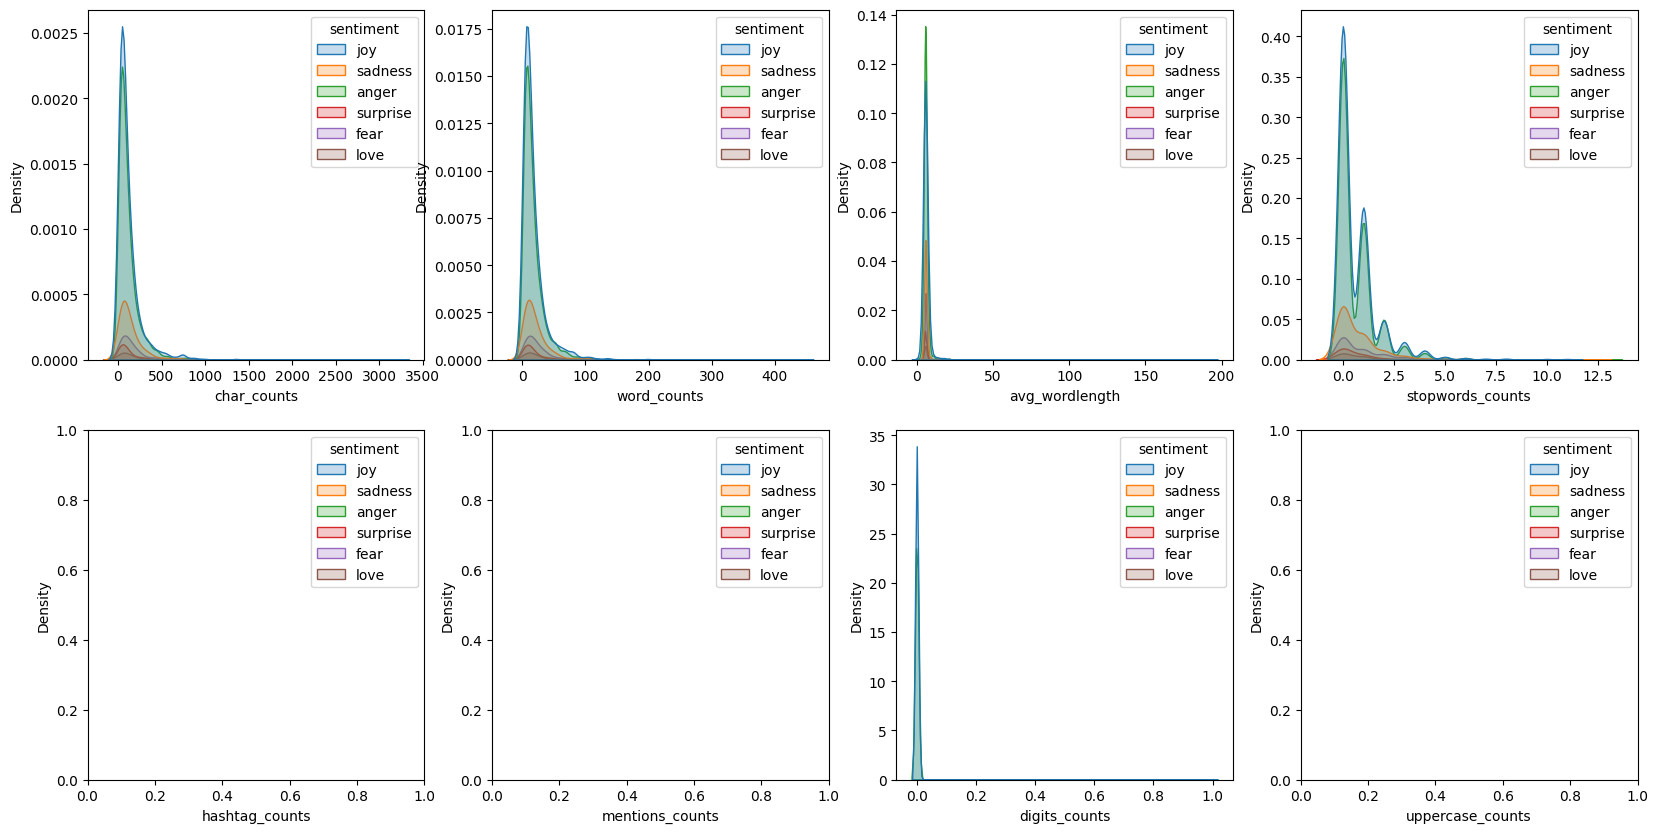

In [72]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# plot 2x4 grid histogram for each numerical feature
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.subplot(2,4, num_cols.get_loc(col)+1)

    # use sentiment as hue to see the distribution of each numerical feature
    # sns.distplot(df[col], label=col, color='red')
    # sns.histplot(x=col, hue='sentiment', data=df, color='green', bins=100, kde=True)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=True)



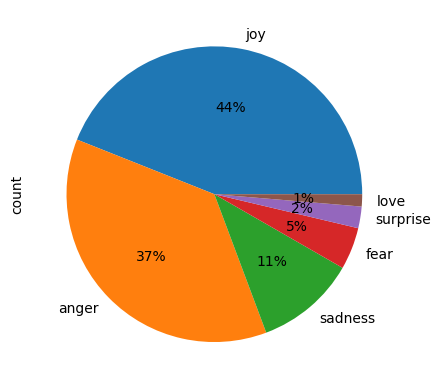

In [73]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

# word cloud
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

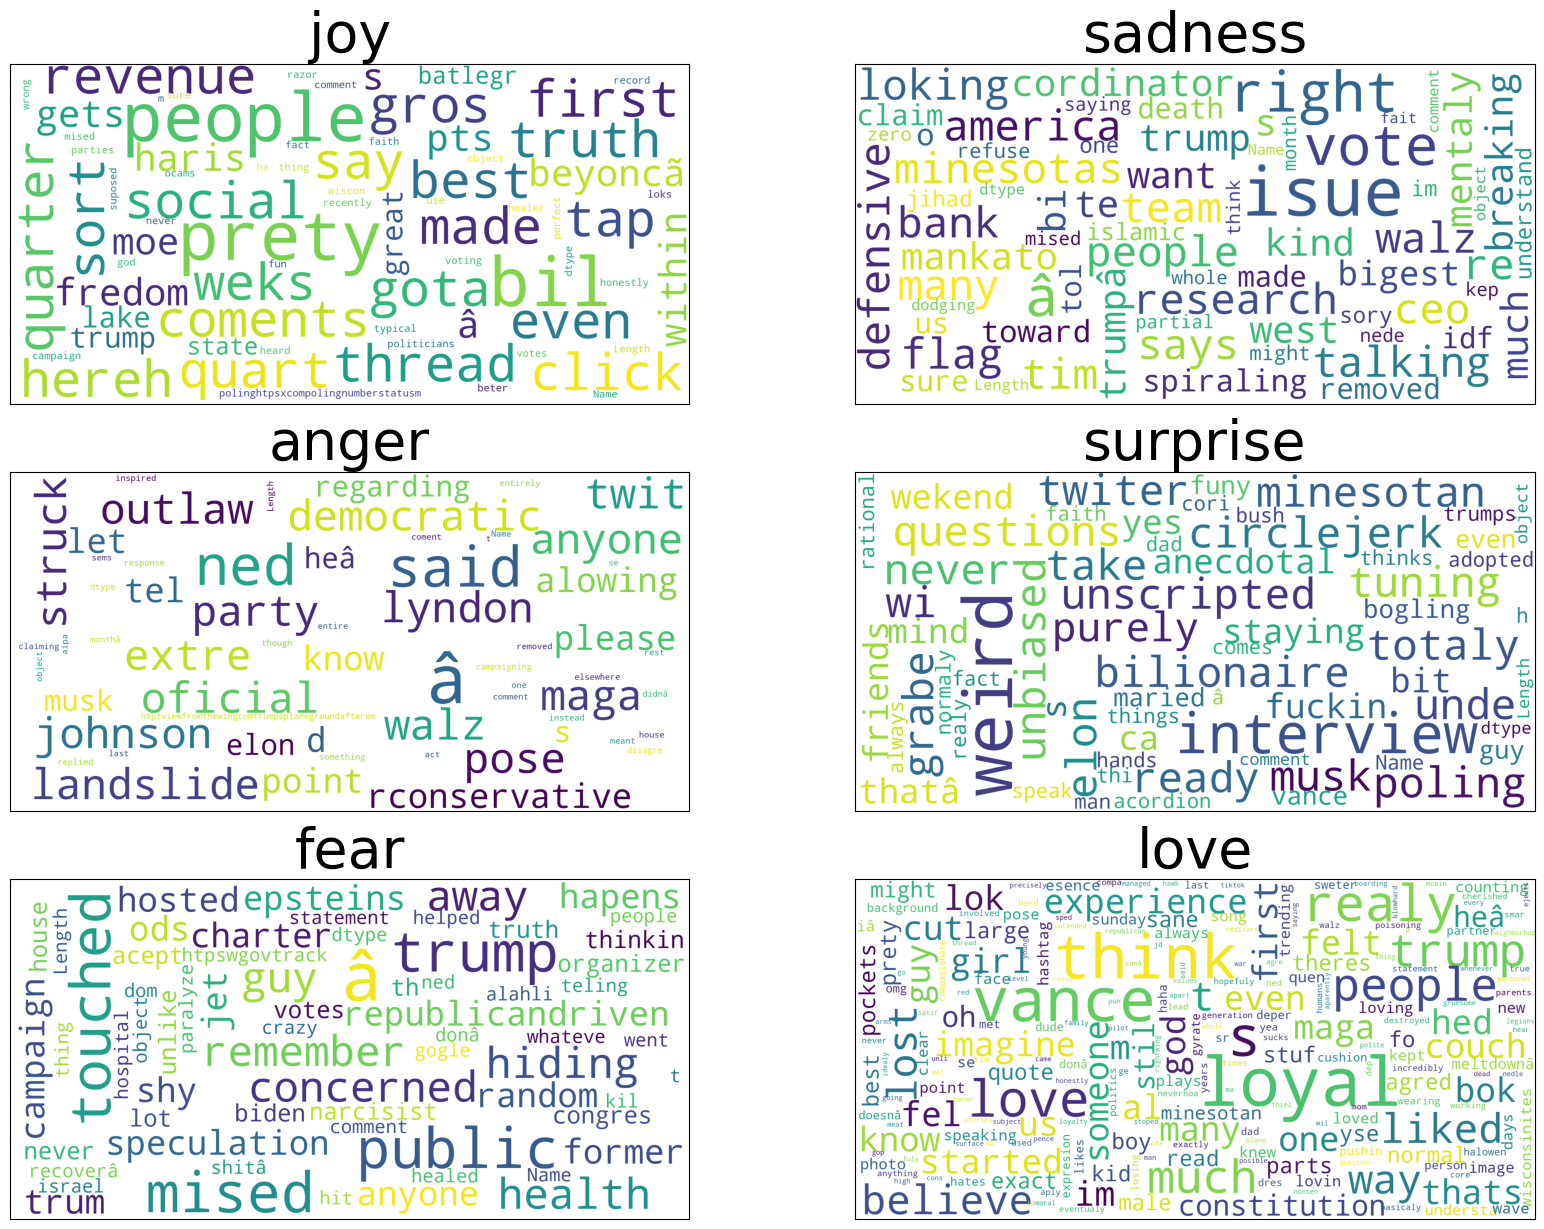

<Figure size 640x480 with 0 Axes>

In [77]:
# Set up a 3x2 grid for the 6 sentiments
plt.figure(figsize=(20, 15))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(3,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['comment']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)
    
plt.show()
plt.tight_layout()


In [79]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['sentiment'], test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Training data shape: (3354,), Testing data shape: (839,)


Explanation:
>The dataset is split into training and testing sets, with 80% of the data used for training and 20% for testing.

>This ensures that the model is trained on one portion of the data and evaluated on a separate, unseen portion.

In [80]:
# Convert STOPWORDS to a list before passing to TfidfVectorizer
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(STOPWORDS))), 
                ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['com', 'with', 'any', "isn't",
                                             'itself', 'its', 'and', 'his',
                                             "she'll", 'hers', 'can',
                                             'yourself', "i've", 'because',
                                             "doesn't", 'do', "you're", 'into',
                                             'otherwise', 'not', "why's",
                                             'before', 'few', "we're", 'ought',
                                             'having', "here's", 'over',
                                             'yours', 'all', ...])),
                ('clf', RandomForestClassifier(n_jobs=-1))])

Explanation:

>A Pipeline is created that first transforms the text data into numerical features using TfidfVectorizer.

>A RandomForestClassifier is then trained on these features.
The model is trained using the training data (X_train and y_train).

>X_train: The training data features (tweets converted to TF-IDF vectors).

>y_train: The corresponding sentiment labels for the training data.

>clf.fit(X_train, y_train): This command trains the entire pipeline:
The TF-IDF vectorizer first transforms the raw text data into numerical vectors.
The Random Forest classifier then trains on these vectors, learning patterns that relate the TF-IDF features to the sentiment labels.


In [81]:
# Model Evaluation
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.5423122765196663


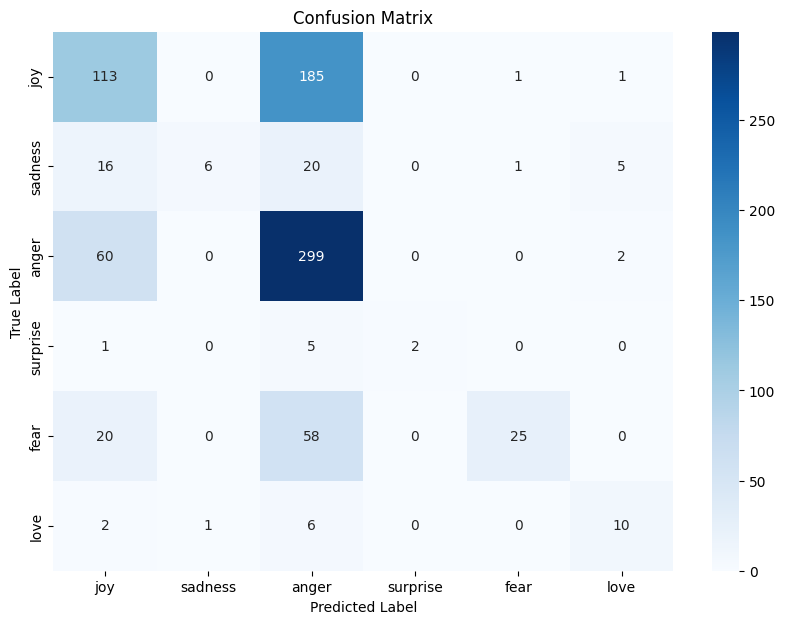

In [82]:

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
predictions = clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Precision, Recall, and F1-Score:


In [83]:
# Precision
precision = precision_score(y_test, predictions, average='weighted')
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print(f"Recall: {recall:.2f}")

# F1-Score
f1 = f1_score(y_test, predictions, average='weighted')
print(f"F1-Score: {f1:.2f}")


Precision: 0.60
Recall: 0.54
F1-Score: 0.51


In [84]:
# Classification Report
class_report = classification_report(y_test, predictions)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

       anger       0.53      0.38      0.44       300
        fear       0.86      0.12      0.22        48
         joy       0.52      0.83      0.64       361
        love       1.00      0.25      0.40         8
     sadness       0.93      0.24      0.38       103
    surprise       0.56      0.53      0.54        19

    accuracy                           0.54       839
   macro avg       0.73      0.39      0.44       839
weighted avg       0.60      0.54      0.51       839



In [88]:
# Save the Model
with open('reddit_sentiment.pkl', 'wb') as model_file, open('test_data.txt', 'w') as test_file:
    pickle.dump(clf, model_file)


In [89]:
# Display some sample predictions
print(X_test.tolist()[:20])


['veting proces bad trump saw peter thiels money trump also ses elmos money', 'trafalgar put thumbs  trump basicaly neck neck', 'you review threadhtpsniterpoastorgjasonriverastlstatusm', 'advertisers definitely coming back posts spam bots point trafic x making cloud server bils that theyre going pay even biger', 'reminder subredit is civil discusionrpoliticswikindexwikibecivil general courteous others debatediscusargue merits ideas atack people personal insults shil trol acusations hate spech sugestion suport harm violence death rule violations result permanent ban se coments violation rules please report them questions regarding media outlets posted subredit please click herehtpswreditcomrpoliticswikiaprovedomainslist review details aproved domains list outlet criteria actively loking new moderators interest helping make subredit place quality discusion please fil this formhtpsdocsgoglecomformsdyswhdkxfhstgfjwkriumjzcfqdivwuvdlbjsa i bot action performed automaticaly please contact mo

In [90]:
X_test.tolist()[:20]

['veting proces bad trump saw peter thiels money trump also ses elmos money',
 'trafalgar put thumbs  trump basicaly neck neck',
 'you review threadhtpsniterpoastorgjasonriverastlstatusm',
 'advertisers definitely coming back posts spam bots point trafic x making cloud server bils that theyre going pay even biger',
 'reminder subredit is civil discusionrpoliticswikindexwikibecivil general courteous others debatediscusargue merits ideas atack people personal insults shil trol acusations hate spech sugestion suport harm violence death rule violations result permanent ban se coments violation rules please report them questions regarding media outlets posted subredit please click herehtpswreditcomrpoliticswikiaprovedomainslist review details aproved domains list outlet criteria actively loking new moderators interest helping make subredit place quality discusion please fil this formhtpsdocsgoglecomformsdyswhdkxfhstgfjwkriumjzcfqdivwuvdlbjsa i bot action performed automaticaly please contac